# 온라인 결제 사기거래 탐지

> 목차

- 문제상황 및 데이터 살펴보기
- 문제해결 프로세스 정의
- Data 전처리 및 EDA
- Feature 상관관계 분석
- 이상 탐지 모델링

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# 대다수의 이상탐지 : 정상/이상 분류(Classification)
# 라벨링이 있는 슈퍼바이즈드의 경우 트리 모델이 잘 됨

# 문제상황 및 데이터 살펴보기

> 시나리오

- A사는 요즘 핫한 중고거래 플랫폼(사이트)를 운영하는 회사다. 최근 플랫폼 내 페이 시스템을 오픈하고, 페이 시스템을 기반으로 서비스를 확장해 나가고 있다. 중고거래 특성상 빈번하게 사기거래가 발생하게 되는데, 최근 사기거래 건수가 급증하고 있어 소비자 피해가 문제되고 있다. 이를 방지하기 위해서 페이 시스템을 통해 수집된 데이터를 기반으로 이상 거래를 사전 탐지하고 방어 활동들을 전개해나가고자 한다.

> 데이터 살펴보기

- 온라인 거래 데이터


데이터명세
1. step : 1step이 1시간인 시간 단위
2. type : 온라인 거래유형
3. amount : 거래 금액
4. nameOrig : 거래 시작 고객
5. oldbalanceOrg : 거래 전 잔액
6. nameDest : 거래 수신 고객
7. oldbalanceOrg : 거래 전 잔액
8. newbalanceOrig : 거래 후 잔액
9. nameDest : 거래 수신 고객
10. oldbalanceDest : 거래 전 수취인의 초기 잔액
11. newbalanceDest : 거래 전 수취인의 초기 잔액
12. isFraud : 사기 거래

In [2]:
# pd.set_option
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data read
df = pd.read_csv("D:\\csv\\chapter05_df.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 문제해결 프로세스 정의

> 문제정의

- 중고 플랫폼 온라인 거래 사기 거래 건수 증가
- 소비자 피해 및 사용자 감소

> 기대효과

- 사기거래 사전 차단으로 소비자 피해 방지
- 신규 회원 증가

> 해결방안 : 사기거래 이상탐지 모델링을 통한 사기거래 사전 차단

- Data전처리 및 EDA
- Feature 상관관계 분석
- 이상 탐지 모델링 수행

> 성과측정 (KPI)

- 모델 활용 전/후 사기거래 건수 비교
- 모델 활용 전/후 사기거래 소비자 피해 금액 비교

> 현업적용

- 온라인 거래 발생 시 거래 데이터 Model Input
- 이상 거래 확인 시 해당 거래 상세 분석 후 조치

> 주요 코드 미리 살펴보기
- 데이터 전처리 및 EDA : list.append(), pd.concat()
- Feature 상관관계 분석 : .value_counts(normalize=True), .groupby('type')['isFraud'].agg(['count', 'sum']), enumerate()
- 모델링 : .drop(), OneHotEncoder(), LogisticRegression()

# 데이터 전처리 및 EDA

### 데이터 전처리
1. Data shape 확인
2. Data Type 확인
3. Null 확인
4. Outlier 확인

In [3]:
# 보유 데이터의 rows와 columns 확인
df.shape

(6362620, 11)

In [4]:
# Data Type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
# Null 갯수 확인
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Outlier 확인 (-가 될 수 없는 값이 - 값으로 존재하는지 확인)
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### 데이터 EDA

- 데이터 특성 파악을 위해서 탐색하는 과정

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
# 데이터가 굉장히 불균형함
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [9]:
# 99.87% : 0.13%
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [10]:
# 의미가 불분명한 데이터 확인
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [11]:
# 숫자형, 범주형 변수 분할
numerical_list = []
categorical_list = []

for i in df.columns:
    # Object
    if df[i].dtypes == 'O':
        categorical_list.append(i)
    # int or float or else
    else:
        numerical_list.append(i)
        
print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

categorical_list : ['type', 'nameOrig', 'nameDest']
numerical_list : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [12]:
# 범주형 변수에서 '유니크값' 이 너무 많은 경우 (ex - 사용자ID)
# 1. 버린다
# 2. 재그룹핑을 한다 (범주별로 집단화하거나 개인을 지역인 기준으로 등)

# nameOrig : 판매자 아이디 (6353307 가지)
# nameDest : 구매자 아이디 (2722362 가지)
list_of_df = []

for var in categorical_list:
    loop_df = pd.DataFrame({'var':[var], 'ncnt':[df[var].nunique()]})
    list_of_df.append(loop_df)

df_concat = pd.concat(list_of_df).reset_index(drop=True)

# 활용하기 어려울 것 같아 두 변수는 drop
df_concat

,var,ncnt
0,type,5
1,nameOrig,6353307
2,nameDest,2722362


# Feature 와 Target변수의 관계분석

In [13]:
# 범주형 데이터 확인
categorical_list

['type', 'nameOrig', 'nameDest']

In [14]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [15]:
df['isFraud'].dtype

dtype('int64')

In [16]:
# type 별로 사기건이 몇개 있는지 확인 (CASH_OUT 과 TRANSFER 에서만 사기가 발생함을 알 수 있음)
temp = df.groupby('type')['isFraud'].agg(['count', 'sum'])
temp

,count,sum
type,,
CASH_IN,1399284,0
CASH_OUT,2237500,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,532909,4097


In [17]:
# type 별 Target Ratio 확인
temp = df.groupby('type')['isFraud'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio']/0.13, 1)
temp

,count,sum,ratio,lift
type,,,,
CASH_IN,1399284,0,0.00,0.0
CASH_OUT,2237500,4116,0.18,1.4
DEBIT,41432,0,0.00,0.0
PAYMENT,2151495,0,0.00,0.0
TRANSFER,532909,4097,0.77,5.9


In [18]:
# nameOrig, 여러번 사기의 포함된 입금자 거래(ID)가 있는지? (없음)
temp = df.groupby('nameOrig')['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count']) * 100, 2)
temp.sort_values(by=['ratio'], ascending=False)

,count,sum,ratio
nameOrig,,,
C1998644906,1,1,100.0
C2064336595,1,1,100.0
C239155420,1,1,100.0
C782313486,1,1,100.0
C2052061131,1,1,100.0
...,...,...,...
C164527924,1,0,0.0
C16452791,1,0,0.0
C164527901,1,0,0.0


In [19]:
# nameDest, 여러번 사기의 포함된 수금자 거래(ID)가 있는가? (없음)
temp = df.groupby('nameDest')['isFraud'].agg(['count', 'sum'])
temp['ratio'] = round((temp['sum'] / temp['count']) * 100, 2)
temp.sort_values(by=['count','ratio'], ascending=False)

,count,sum,ratio
nameDest,,,
C1286084959,113,0,0.0
C985934102,109,0,0.0
C665576141,105,0,0.0
C2083562754,102,0,0.0
C1590550415,101,0,0.0
...,...,...,...
M999998692,1,0,0.0
M99999900,1,0,0.0
M999999089,1,0,0.0


### numeric val & 'isFraud' 분석

In [20]:
# 수치형 데이터 확인
numerical_list

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [21]:
# 수치형 데이터 확인
df[numerical_list].head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [22]:
# 구간화작업(binning)을 하기 위한 준비
df_num = df[numerical_list]
df_num_des = pd.DataFrame(df_num.describe())
df_num_des

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [23]:
# 사용하지않을 Target 변수 Drop (필요한 컬럼들만 리스트로 만듦)
num_list = df_num_des[numerical_list].columns[:-2]
num_list

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [24]:
# 수치형 변수 단위따라 binning
import numpy as np

for i, col in enumerate(num_list):
    bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
    feature_nm = col + '_gp'
    df_num[feature_nm] = np.digitize(df_num[col], bins)

In [25]:
# 기존 Column
df_num.columns[0:6]

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [26]:
# 신규 Column
df_num.columns[8:]

Index(['step_gp', 'amount_gp', 'oldbalanceOrg_gp', 'newbalanceOrig_gp',
       'oldbalanceDest_gp', 'newbalanceDest_gp'],
      dtype='object')

In [27]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [28]:
# Lift 계산
list_of_df = []
Target_ratio = 0.13

for i in df_num.columns[0:6]:
    gp = i+'_gp'
    temp = df_num.groupby(gp)['isFraud'].agg(['count', 'sum'])
    temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
    temp['lift'] = round(temp['ratio'] / Target_ratio, 2)
    temp_df = pd.DataFrame(temp)
    gap = temp_df['lift'].max() - temp_df['lift'].min()
    loop_df = pd.DataFrame([[i, gap]], columns=['val','gap'])
    list_of_df.append(loop_df)
    
df_accum_start = pd.concat(list_of_df)

In [29]:
len(df_accum_start)

6

In [54]:
# lift max-min Gap이 큰 데이터부터 Sorting
df_accum_start.sort_values(by=['gap'], ascending=False).head()

,val,gap
0,oldbalanceOrg,2.77
0,amount,2.47
0,step,1.69
0,newbalanceOrig,1.23
0,oldbalanceDest,0.69


In [55]:
# oldbalanceOrg_gp 확인
gp = 'oldbalanceOrg_gp'

temp = df_num.groupby(gp)['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio'] / 0.13, 2)
pd.DataFrame(temp)

,count,sum,ratio,lift
oldbalanceOrg_gp,,,,
2,4771965,1827,0.04,0.31
3,1590655,6386,0.40,3.08


In [56]:
# bin 확인
i = 'oldbalanceOrg'
bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
bins

[0.0, 0.0, 107315.175, inf]

In [57]:
# amount_gp 확인
gp = 'amount_gp'

temp = df_num.groupby(gp)['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio'] / 0.13, 2)
pd.DataFrame(temp)

,count,sum,ratio,lift
amount_gp,,,,
1,1590653,334,0.02,0.15
2,3181312,2475,0.08,0.62
3,1590655,5404,0.34,2.62


In [58]:
# bin 확인
i = 'amount'
bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
bins

[0.0, 13389.57, 208721.4775, inf]

In [59]:
# step_gp 확인
gp = 'step_gp'

temp = df_num.groupby(gp)['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio'] / 0.13, 2)
pd.DataFrame(temp)

,count,sum,ratio,lift
step_gp,,,,
1,1590035,1762,0.11,0.85
2,3181352,1983,0.06,0.46
3,1591233,4468,0.28,2.15


In [60]:
# bin 확인
i = 'step'
bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
bins

[1.0, 156.0, 335.0, inf]

In [61]:
# newbalanceOrig_gp 확인
gp = 'newbalanceOrig_gp'

temp = df_num.groupby(gp)['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio'] / 0.13, 2)
pd.DataFrame(temp)

,count,sum,ratio,lift
newbalanceOrig_gp,,,,
2,4771964,8053,0.17,1.31
3,1590656,160,0.01,0.08


In [62]:
# bin 확인
i = 'newbalanceOrig'
bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
bins

[0.0, 0.0, 144258.41, inf]

In [63]:
# oldbalanceDest_gp 확인
gp = 'oldbalanceDest_gp'

temp = df_num.groupby(gp)['isFraud'].agg(['count','sum'])
temp['ratio'] = round((temp['sum'] / temp['count'])*100, 2)
temp['lift'] = round(temp['ratio'] / 0.13, 2)
pd.DataFrame(temp)

,count,sum,ratio,lift
oldbalanceDest_gp,,,,
2,4771965,7290,0.15,1.15
3,1590655,923,0.06,0.46


In [64]:
# bin 확인
i = 'oldbalanceDest'
bins = [df_num_des.loc['min'][i], df_num_des.loc['25%'][i], df_num_des.loc['75%'][i], np.inf]
bins

[0.0, 0.0, 943036.7075, inf]

### PCA 진행

# 이상 탐지 모델링

### Model Selection

In [ ]:
# LOF (상대밀도기반 알고리즘)

# 대부분의 이상탐지 알고리즘은 Global(전역) 관점에서 개별의 관측치가 이상인지 판별
# 위 단점을 극복하기 위해 Local(국소적) 정보를 이용하여 이상인지 판별함
# LOF는 관측치가 데이터 안에서 얼마나 벗어나 있는가에 대한 정도를 나타냄
# 'K' Hyper parameter를 통해 주변 데이터를 몇 개까지 고려할지를 결정
# LOF < 1 : 밀도가 높은 분포
# LOF = 1 : 이웃 관측치와 비슷한 분포
# LOF > 1 : 밀도가 낮은분포, 크면 클수록 이상치 정도가 큼

In [65]:
# LOF 장단점

'''
[good] 굉장히 밀접한 클러스터에서 조금만 떨어져 있어도 이상치로 탐지
[good] 특별한 라벨링이 없어도 사용할 수 있음
[good] Local Outlier를 탐지할 수 있음
[good] 데이터에 대한 가정이 필요 없음
[bad] 데이터의 차원수가 증가할 수록 계산량이 많음 (차원수가 많은 데이터에 대해서는 사용할 수 없음)
[bad] 이상치 판단 기준 설정 어려움 (밀접도가 다른 여러 클러스터가 존재한다면 민감하게 반응함)
'''

'\n[good] 굉장히 밀접한 클러스터에서 조금만 떨어져 있어도 이상치로 탐지\n[good] 특별한 라벨링이 없어도 사용할 수 있음\n[good] Local Outlier를 탐지할 수 있음\n[good] 데이터에 대한 가정이 필요 없음\n[bad] 데이터의 차원수가 증가할 수록 계산량이 많음\n[bad] 이상치 판단 기준 설정 어려움 (밀접도가 다른 여러 클러스터가 존재한다면 민감하게 반응함)\n'

### Data pre-processing

In [69]:
# 미사용 column 사전 Drop
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df

KeyError: "['nameOrig', 'nameDest'] not found in axis"

In [73]:
# 숫자형, 범주형 변수 분할 (One Hot Encoder 사용을 위해)
numerical_list = []
categorical_list = []

for i in df.columns:
    if df[i].dtypes == 'object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
        
print('categorical_list :', categorical_list)
print('numerical_list :', numerical_list)

categorical_list : ['type']
numerical_list : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [76]:
# 범주형 변수를 모델이 이해하기 위해 숫자형 데이터로 변환해줘야한다 (OneHotEncoder)
# 변수형 변수의 Level이 예제와 같이 많다고 하면, 다른 인코딩 방법을 고려해볼 수도 있음 (Binary encoding, Hash encoding 등)
# 모든 방법을 테스트해보고 성능을 고려하는 것이 Best
# 회귀식 알고리즘에는 숫자정렬이 영향을 미칠수도 있기 때문에 인코딩 사용이 어려움

from sklearn.preprocessing import OneHotEncoder

for col in categorical_list:
    encoder = OneHotEncoder()
    onehot = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray(), columns=encoder.get_feature_names_out())
    
    # 붙여주고 기존 Column은 삭제
    df = pd.concat([df, onehot], axis=1).drop(columns=[col])

In [77]:
onehot

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
6362615,0.0,1.0,0.0,0.0,0.0
6362616,0.0,0.0,0.0,0.0,1.0
6362617,0.0,1.0,0.0,0.0,0.0
6362618,0.0,0.0,0.0,0.0,1.0


In [78]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


In [79]:
# 데이터를 학습과 테스트셋으로 나눈다
# Train-Test Set split
from sklearn.model_selection import train_test_split

X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)        # 사용하지 않을 변수 드랍
Y = df['isFraud']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y, random_state=123)     # 7:3 분할

print(f'x_train shape : {x_train.shape}')
print(f'x_test shape : {x_test.shape}')
print(f'y_train shape : {y_train.shape}')
print(f'y_test shape : {y_test.shape}')

x_train shape : (4453834, 11)
x_test shape : (1908786, 11)
y_train shape : (4453834,)
y_test shape : (1908786,)


In [80]:
# 분포도 비교
# Train data Target ratio 확인
pd.Series(y_train).value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

# 모델 학습 및 평가

In [81]:
# 모델이 성능이 안좋으면 바꿔서 진행한다 (->Isolation Forest)
from sklearn.ensemble import IsolationForest

# Model 학습 및 예측
# n_estimators : 나무의 개수 (default 100)
# max_samples : 샘플링 데이터 개수 (정수, 실수(0~1), 전체 데이터 개수 or 256 중 작은 수)
# contamination : 전체 데이터에서 이상치의 비율, 이 비율에 따라 이상치로 판단하기 위한 score의 threshold를 정의
# max_features : 학습 시 사용할 Feature (default 1, 모두 사용)

clf = IsolationForest(max_samples=200, contamination=0.002, random_state=42)
clf.fit(x_train)

y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)

In [82]:
# 평가를 위해 재 라벨링 (-1은 1로, 아니면 0으로)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

In [83]:
# 변경된 값 확인
y_pred_train[0:5], y_pred_test[0:5]

(array([0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0]))

In [84]:
# 성능평가
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448085
           1       0.02      0.03      0.02      5749

    accuracy                           1.00   4453834
   macro avg       0.51      0.51      0.51   4453834
weighted avg       1.00      1.00      1.00   4453834

----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.02      0.03      0.02      2464

    accuracy                           1.00   1908786
   macro avg       0.51      0.51      0.51   1908786
weighted avg       1.00      1.00      1.00   1908786



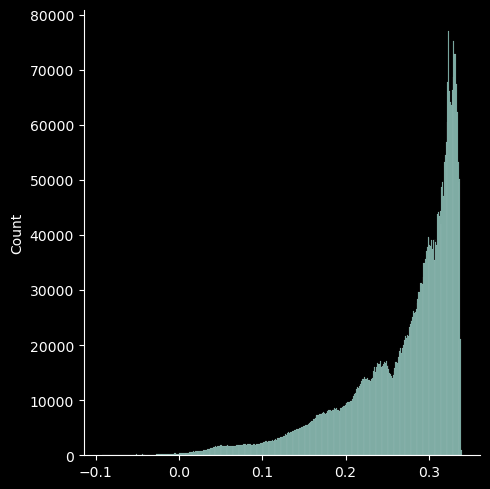

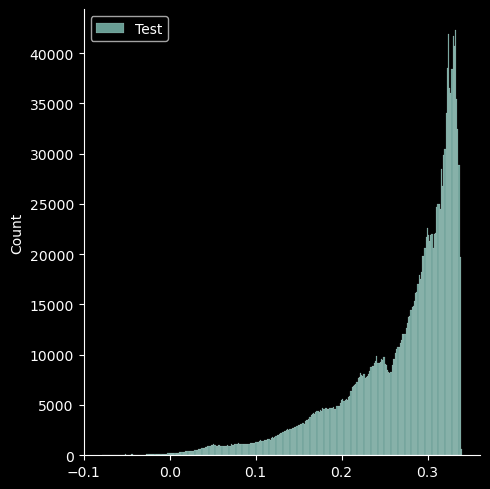

In [85]:
# 분포 시각화를 통해 Threshold 조정 (Train set / Test set)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

sns.displot(clf.decision_function(x_train), label='Train');
sns.displot(clf.decision_function(x_test), label='Test');
plt.legend();

### Classification model 기반 A.D

- 비지도 학습 알고리즘이 정확도가 너무 떨어져서 지도 학습으로 변경

In [86]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)    # 지도학습은 결과값을 넣는다

LogisticRegression()

In [87]:
pred_lr = lr.predict(x_train)
print(classification_report(y_train, pred_lr))

# precision : 예측한 것 중 얼마나 정답이냐? (분모가 예측개수 6871)
# recall : 실제있는 것 중 얼마나 예측했냐? (분모가 실제개수 5749)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448085
           1       0.36      0.43      0.39      5749

    accuracy                           1.00   4453834
   macro avg       0.68      0.71      0.69   4453834
weighted avg       1.00      1.00      1.00   4453834



In [89]:
# 예측 데이터 갯수를 출력하여 실제 support와 비교확인 (실제이상: 5749개, 예측이상: 6871개)
pd.Series(pred_lr).value_counts()

0    4446963
1       6871
dtype: int64

In [88]:
# train셋과 test셋의 결과가 크게 차이나지 않는다는 것은 '과적합'이 일어나지 않았다는 의미로 볼 수 있다
pred_lr_test_set = lr.predict(x_test)
print(classification_report(y_test, pred_lr_test_set))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.36      0.42      0.38      2464

    accuracy                           1.00   1908786
   macro avg       0.68      0.71      0.69   1908786
weighted avg       1.00      1.00      1.00   1908786

